# Basic Neural Network Modifications and Their Effects

## This a set of tests to see how changing a simple neural network affects its accuracy, loss, and training time. The tests are based on an example in section 3.4 of Francois Chollet's book *Deep Learning with Python* and its recommendations for experiments

In [1]:
import numpy as np

In [2]:
from keras.datasets import imdb
from keras import models, layers

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt

In [4]:
from timeit import default_timer

In [5]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [6]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [7]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [8]:
number_of_tests = 9

training_times = np.zeros(number_of_tests + 1)
test_accuracies = np.zeros(number_of_tests + 1)

test_number = 1

In [9]:
model_1 = models.Sequential()
model_1.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model_1.add(layers.Dense(16, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [12]:
model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

training_times[test_number] = default_timer()
history_1 = model_1.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_1.evaluate(x_test, y_test)

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 6s 382us/step - loss: 0.4976 - acc: 0.7957 - val_loss: 0.3718 - val_acc: 0.8718
Epoch 2/20
15000/15000 [==============================] - 4s 272us/step - loss: 0.2958 - acc: 0.9046 - val_loss: 0.2991 - val_acc: 0.8905
Epoch 3/20
15000/15000 [==============================] - 4s 259us/step - loss: 0.2160 - acc: 0.9286 - val_loss: 0.3085 - val_acc: 0.8719
Epoch 4/20
15000/15000 [==============================] - 4s 261us/step - loss: 0.1741 - acc: 0.9431 - val_loss: 0.2831 - val_acc: 0.8846
Epoch 5/20
15000/15000 [==============================] - 4s 272us/step - loss: 0.1414 - acc: 0.9543 - val_loss: 0.2863 - val_acc: 0.8851
Epoch 6/20
15000/15000 [==============================] - 4s 276us/step - loss: 0.1142 - acc: 0.9655 - val_loss: 0.3077 - val_acc: 0.8816
Epoch 7/20
15000/15000 [==============================] - 4s 282us/step - 

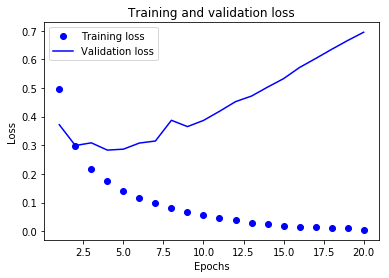

In [13]:
history_dict = history_1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

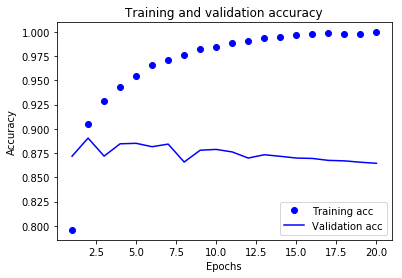

In [15]:
plt.clf()

val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
def graph_loss_and_accuracy(training_data):
    history_dict = training_data.history
    loss_values = history_dict['loss']
    acc_values = history_dict['acc']

    epochs = range(1, len(acc_values) + 1)

    plt.clf()
    
    plt.plot(epochs, loss_values, 'ro', label='Training loss')
    plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Loss:0.7558236665701866Accuracy:0.85156


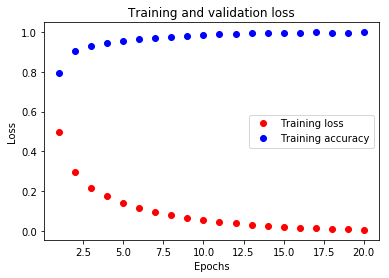

In [17]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_1)

test_number += 1

In [18]:
model_2 = models.Sequential()
model_2.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

training_times[test_number] = default_timer()
history_2 = model_2.fit(x_train, y_train, epochs=4, batch_size=512)
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_2.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 7s 272us/step - loss: 0.4749 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 5s 198us/step - loss: 0.2666 - acc: 0.9095
Epoch 3/4
25000/25000 [==============================] - 4s 176us/step - loss: 0.1986 - acc: 0.9294
Epoch 4/4
25000/25000 [==============================] - 7s 290us/step


Loss:0.324282718667984Accuracy:0.87296


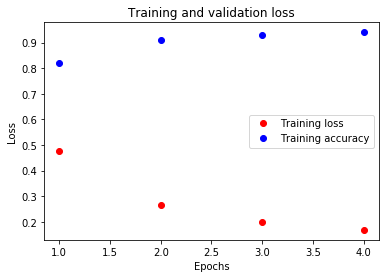

In [19]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_2)

test_number += 1

In [20]:
model_3 = models.Sequential()
model_3.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

training_times[test_number] = default_timer()
history_3 = model_3.fit(x_train, y_train, epochs=4, batch_size=512)
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_3.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 5s 212us/step - loss: 0.4477 - acc: 0.8325
Epoch 2/4
25000/25000 [==============================] - 5s 189us/step - loss: 0.2797 - acc: 0.9077
Epoch 3/4
25000/25000 [==============================] - 4s 178us/step - loss: 0.2214 - acc: 0.9244
Epoch 4/4
25000/25000 [==============================] - 5s 216us/step


Loss:0.27894226531982425Accuracy:0.8888


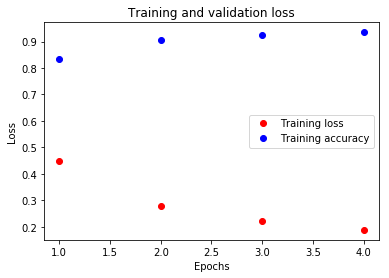

In [21]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_3)

test_number += 1

In [22]:
model_4 = models.Sequential()
model_4.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model_4.add(layers.Dense(16, activation='relu'))
model_4.add(layers.Dense(16, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

training_times[test_number] = default_timer()
history_4 = model_4.fit(x_train, y_train, epochs=4, batch_size=512)
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_4.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 5s 202us/step - loss: 0.4602 - acc: 0.8177
Epoch 2/4
25000/25000 [==============================] - 5s 181us/step - loss: 0.2506 - acc: 0.9108
Epoch 3/4
25000/25000 [==============================] - 5s 183us/step - loss: 0.2008 - acc: 0.9260
Epoch 4/4
25000/25000 [==============================] - 5s 217us/step


Loss:0.3076656979751587Accuracy:0.88016


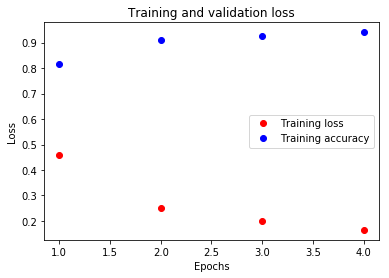

In [23]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_4)

test_number += 1

In [24]:
model_5 = models.Sequential()
model_5.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model_5.add(layers.Dense(32, activation='relu'))
model_5.add(layers.Dense(1, activation='sigmoid'))

model_5.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

training_times[test_number] = default_timer()
history_5 = model_5.fit(x_train, y_train, epochs=4, batch_size=512)
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_5.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 5s 218us/step - loss: 0.4273 - acc: 0.8263
Epoch 2/4
25000/25000 [==============================] - 5s 181us/step - loss: 0.2414 - acc: 0.9114
Epoch 3/4
25000/25000 [==============================] - 4s 176us/step - loss: 0.1863 - acc: 0.9319
Epoch 4/4
25000/25000 [==============================] - 5s 209us/step


Loss:0.3319403140449524Accuracy:0.87272


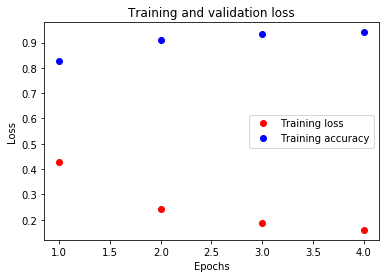

In [25]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_5)

test_number += 1

In [26]:
model_6 = models.Sequential()
model_6.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_6.add(layers.Dense(64, activation='relu'))
model_6.add(layers.Dense(1, activation='sigmoid'))

model_6.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

training_times[test_number] = default_timer()
history_6 = model_6.fit(x_train, y_train, epochs=4, batch_size=512)
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_6.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 7s 264us/step - loss: 0.4191 - acc: 0.8134
Epoch 2/4
25000/25000 [==============================] - 6s 226us/step - loss: 0.2412 - acc: 0.9072
Epoch 3/4
25000/25000 [==============================] - 5s 211us/step - loss: 0.1850 - acc: 0.9304
Epoch 4/4
25000/25000 [==============================] - 6s 239us/step


Loss:0.33008490878582003Accuracy:0.87628


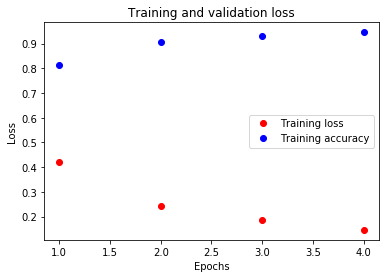

In [27]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_6)

test_number += 1

In [28]:
model_7 = models.Sequential()
model_7.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model_7.add(layers.Dense(8, activation='relu'))
model_7.add(layers.Dense(1, activation='sigmoid'))

model_7.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

training_times[test_number] = default_timer()
history_7 = model_7.fit(x_train, y_train, epochs=4, batch_size=512)
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_7.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 5s 200us/step - loss: 0.5327 - acc: 0.7932
Epoch 2/4
25000/25000 [==============================] - 4s 159us/step - loss: 0.3334 - acc: 0.8986
Epoch 3/4
25000/25000 [==============================] - 4s 161us/step - loss: 0.2461 - acc: 0.9188
Epoch 4/4
25000/25000 [==============================] - 5s 201us/step


Loss:0.2872181939125061Accuracy:0.8852


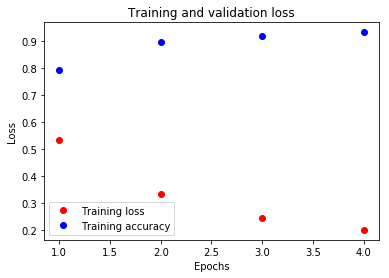

In [29]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_7)

test_number += 1

In [30]:
model_8 = models.Sequential()
model_8.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model_8.add(layers.Dense(16, activation='relu'))
model_8.add(layers.Dense(1, activation='sigmoid'))

model_8.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

training_times[test_number] = default_timer()
history_8 = model_8.fit(x_train, y_train, epochs=4, batch_size=512)
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_8.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 5s 204us/step - loss: 0.1442 - acc: 0.8188
Epoch 2/4
25000/25000 [==============================] - 4s 165us/step - loss: 0.0774 - acc: 0.9106
Epoch 3/4
25000/25000 [==============================] - 4s 165us/step - loss: 0.0581 - acc: 0.9324
Epoch 4/4
25000/25000 [==============================] - 5s 203us/step


Loss:0.08598677134990693Accuracy:0.88416


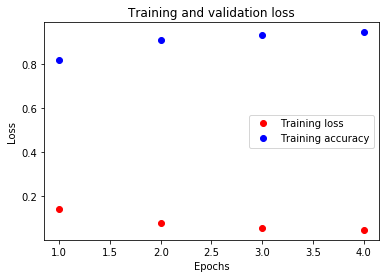

In [31]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_8)

test_number += 1

In [32]:
model_9 = models.Sequential()
model_9.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model_9.add(layers.Dense(16, activation='tanh'))
model_9.add(layers.Dense(1, activation='sigmoid'))

model_9.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

training_times[test_number] = default_timer()
history_9 = model_9.fit(x_train, y_train, epochs=4, batch_size=512)
training_times[test_number] = default_timer() - training_times[test_number]

loss, test_accuracies[test_number] = model_9.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 6s 234us/step - loss: 0.4143 - acc: 0.8289
Epoch 2/4
25000/25000 [==============================] - 4s 170us/step - loss: 0.2308 - acc: 0.9134
Epoch 3/4
25000/25000 [==============================] - 4s 170us/step - loss: 0.1761 - acc: 0.9342
Epoch 4/4
25000/25000 [==============================] - 5s 218us/step


Loss:0.3312265526914597Accuracy:0.87564


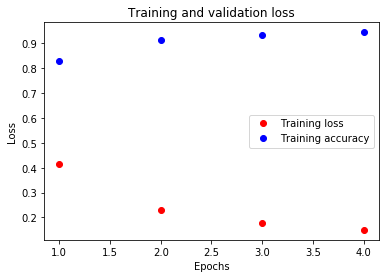

In [33]:
print('Loss:' + str(loss) + 'Accuracy:' + str(test_accuracies[test_number]))
graph_loss_and_accuracy(history_9)

test_number += 1

In [35]:
#TODO plot training time versus test accuracies

print(training_times)
print(test_accuracies)

[ 0.         82.98883797 21.09790848 20.93703083 18.89358635 19.24259243
 23.54982144 17.52497365 17.79077205 19.03311829]
[0.      0.85156 0.87296 0.8888  0.88016 0.87272 0.87628 0.8852  0.88416
 0.87564]
